In [83]:
import xgboost as xgb
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import root_mean_squared_error
from bayes_opt import BayesianOptimization

In [84]:
#df = pd.read_csv('../data/sample submission.csv')
df = pd.read_csv('../data/data2.csv', sep=';', encoding='latin1')
print(df)

          Id     Category   Manufacturer     Model  Prod. year Gear box type  \
0       2680         Jeep        HYUNDAI        H1        2014     Automatic   
1       5960        Sedan     MITSUBISHI    Mirage        2002     Automatic   
2       2185         Jeep        HYUNDAI  Santa FE        2014     Automatic   
3      15905        Sedan  MERCEDES-BENZ     E 260        1992        Manual   
4      15337    Universal          HONDA       FIT        2015     Automatic   
...      ...          ...            ...       ...         ...           ...   
16346  19198         Jeep         TOYOTA     RAV 4        2015     Automatic   
16347   3583        Sedan         TOYOTA     Prius        2009     Automatic   
16348  18497         Jeep      SSANGYONG    REXTON        2015     Automatic   
16349   4565  Goods wagon           OPEL     Combo        2011        Manual   
16350  11586        Sedan           FORD    Fusion        2013     Automatic   

      Leather interior Fuel type Engine

# DATOS FALTANTES

In [85]:
# verificar datos faltantes
for col in df.columns.to_list():
  calc = (df[col].isna().sum()/df.shape[0])*100
  print(f'{col} missing Values: {calc}%')

Id missing Values: 0.0%
Category missing Values: 0.0%
Manufacturer missing Values: 0.0%
Model missing Values: 0.0%
Prod. year missing Values: 0.0%
Gear box type missing Values: 0.0%
Leather interior missing Values: 0.0%
Fuel type missing Values: 0.0%
Engine volume missing Values: 0.0%
Drive wheels missing Values: 0.0%
Cylinders missing Values: 0.0%
Mileage missing Values: 0.0%
Doors missing Values: 0.0%
Airbags missing Values: 0.0%
Wheel missing Values: 0.0%
Color missing Values: 0.0%
Sales Fee missing Values: 0.0%
price missing Values: 0.0%


# VARIABLES CATEGÓRICAS

## ENCODING

In [86]:
def label_encoding(dataset, column_name):
    label_encoder = LabelEncoder()
    dataset[column_name] = label_encoder.fit_transform(dataset[column_name])
    return dataset, label_encoder

def frequency_encoding(dataset, col):
    freq = dataset[col].value_counts(normalize=True)
    dataset[col] = dataset[col].map(freq)
    return dataset, freq

In [87]:
df2 = df
def to_zero(n):
  if n == '-': return 0
  return n

def mileage_km(n):
  return n.replace(' km', '')

def turbo(n):
  if 'Turbo' in n: return 1
  return 0

def engine_volume(n):
  return n.replace(' Turbo', '')

def doors(n):
  if n == '>5': return 6
  return n


df2['Turbo'] = df2['Engine volume'].map(turbo)

In [88]:

df2['Sales Fee'] = df2['Sales Fee'].map(to_zero)
df2['Mileage'] = df2['Mileage'].map(mileage_km)
df2['Engine volume'] = df2['Engine volume'].map(engine_volume)
df2['Doors'] = df2['Doors'].map(doors)

df2.head(20)

,Id,Category,Manufacturer,Model,Prod. year,Gear box type,Leather interior,Fuel type,Engine volume,Drive wheels,Cylinders,Mileage,Doors,Airbags,Wheel,Color,Sales Fee,price,Turbo
0,2680,Jeep,HYUNDAI,H1,2014,Automatic,Yes,Diesel,2.5,Front,4,74210,4,4,Left wheel,Silver,777,22433,0
1,5960,Sedan,MITSUBISHI,Mirage,2002,Automatic,No,Petrol,1.8,Front,4,160000,4,2,Left wheel,White,0,7500,0
2,2185,Jeep,HYUNDAI,Santa FE,2014,Automatic,Yes,Diesel,2,Front,4,51106,4,4,Left wheel,White,639,27284,0
3,15905,Sedan,MERCEDES-BENZ,E 260,1992,Manual,No,CNG,2.6,Rear,6,0,4,4,Left wheel,Beige,0,3450,0
4,15337,Universal,HONDA,FIT,2015,Automatic,Yes,Hybrid,1.5,Front,4,35624,4,4,Left wheel,Black,308,26644,0
5,13792,Hatchback,HONDA,FIT,2014,Automatic,Yes,Petrol,1.5,Front,4,78000,4,4,Left wheel,White,501,25638,0
6,12015,Microbus,FORD,Transit,2007,Manual,No,Diesel,2.4,Rear,4,165000,4,2,Left wheel,Blue,0,17249,0
7,307,Sedan,TOYOTA,Camry,2015,Automatic,Yes,Hybrid,2.5,Front,4,35000,4,10,Left wheel,Grey,456,39201,0
8,1054,Sedan,TOYOTA,Camry,2012,Automatic,Yes,Hybrid,2.5,Front,4,156518,4,12,Left wheel,White,781,3607,0
9,7945,Sedan,HYUNDAI,Elantra,2012,Automatic,Yes,Petrol,1.6,Front,4,165294,4,4,Left wheel,Silver,531,16308,0


In [89]:
df2, freq_category = frequency_encoding(df2, 'Category')
df2, freq_manufacturer = frequency_encoding(df2, 'Manufacturer')
df2, freq_model = frequency_encoding(df2, 'Model')
# Prod. Year
df2, freq_gear_box_type = frequency_encoding(df2, 'Gear box type')
df2, freq_leather_interior = frequency_encoding(df2, 'Leather interior')
df2, freq_fuel_type = frequency_encoding(df2, 'Fuel type')
# Engine volume: quitar el turbo y crear variable aparte
df2, freq_drive_wheels = frequency_encoding(df2, 'Drive wheels')
# Cylinders
df2, freq_mileage = frequency_encoding(df2, 'Mileage') # quitar km
# Doors: cambiar >5 por 4
# Airbags
df2, freq_wheel = frequency_encoding(df2, 'Wheel')
df2, freq_color = frequency_encoding(df2, 'Color')
# Sales Fee: cambiar '-' por '0'
df2.head()

,Id,Category,Manufacturer,Model,Prod. year,Gear box type,Leather interior,Fuel type,Engine volume,Drive wheels,Cylinders,Mileage,Doors,Airbags,Wheel,Color,Sales Fee,price,Turbo
0,2680,0.287567,0.196869,0.022567,2014,0.702832,0.725216,0.211363,2.5,0.670907,4,0.000061,4,4,0.922512,0.195951,777,22433,0
1,5960,0.453183,0.015106,0.000428,2002,0.702832,0.274784,0.528286,1.8,0.670907,4,0.006483,4,2,0.922512,0.233380,0,7500,0
2,2185,0.287567,0.196869,0.027521,2014,0.702832,0.725216,0.211363,2,0.670907,4,0.000122,4,4,0.922512,0.233380,639,27284,0
3,15905,0.453183,0.105315,0.000061,1992,0.096875,0.274784,0.024524,2.6,0.118097,6,0.036817,4,4,0.922512,0.006850,0,3450,0
4,15337,0.018592,0.050028,0.022690,2015,0.702832,0.725216,0.185065,1.5,0.670907,4,0.000061,4,4,0.922512,0.261941,308,26644,0


In [90]:
for col in df2.columns:
    df2[col] = pd.to_numeric(df2[col])

In [91]:
# Interaction terms
df2['Doors_Category'] = df2['Doors'] * df2['Category']
df2['Engine_volume_Cylinders'] = df2['Engine volume'] * df2['Cylinders']
df2['Prod_year_Mileage'] = df2['Prod. year'] * df2['Mileage']

# Additional interaction terms
df2['Doors_ProdYear'] = df2['Doors'] * df2['Prod. year']
df2['Mileage_SalesFee'] = df2['Mileage'] * df2['Sales Fee']
df2['Category_Turbo'] = df2['Category'] * df2['Turbo']

# Polynomial terms
df2['Mileage_Squared'] = df2['Mileage'] ** 2
df2['EngineVolume_Squared'] = df2['Engine volume'] ** 2

# Ratios
df2['EngineVolume_per_Cylinder'] = df2['Engine volume'] / df2['Cylinders']
df2['Mileage_per_Door'] = df2['Mileage'] / df2['Doors']

# Age feature
df2['Car_Age'] = 2024 - df2['Prod. year']

# Interaction with age
df2['Age_Mileage'] = df2['Car_Age'] * df2['Mileage']
df2['Age_SalesFee'] = df2['Car_Age'] * df2['Sales Fee']

# Log transformations (to handle skewness)
df2['Log_Mileage'] = np.log1p(df2['Mileage'])
df2['Log_EngineVolume'] = np.log1p(df2['Engine volume'])
df2['Log_SalesFee'] = np.log1p(df2['Sales Fee'])

# OUTLIERS

In [92]:
# Tratar con outliers
def cuantificaOutliers(dataset):
  for col in dataset.columns:
    q1, q3 = np.percentile(dataset[col],[25,75])
    iqr = q3-q1
    lower_bound = q1 - (1.5*iqr)
    upper_bound = q3 + (1.5*iqr)
    outlier = dataset[(dataset[col]<lower_bound)|(dataset[col]>upper_bound)]
    if (outlier.shape[0] > 0):
      print(col, ' ', outlier.shape[0], ' ', outlier.shape[0]/dataset.shape[0]*100, '%')

cuantificaOutliers(df2)

Prod. year   824   5.039447128615987 %
Engine volume   1184   7.241147330438505 %
Cylinders   4140   25.31955232095896 %
Mileage   2015   12.323405296312153 %
Doors   763   4.666381261084949 %
Wheel   1267   7.7487615436364745 %
Sales Fee   136   0.831753409577396 %
price   901   5.510366338450248 %
Turbo   1618   9.89541924041343 %
Engine_volume_Cylinders   3426   20.952846920677633 %
Prod_year_Mileage   2014   12.3172894624182 %
Doors_ProdYear   1424   8.708947464986851 %
Mileage_SalesFee   2533   15.491407253378997 %
Category_Turbo   1618   9.89541924041343 %
Mileage_Squared   2750   16.81854320836646 %
EngineVolume_Squared   2373   14.512873830346768 %
EngineVolume_per_Cylinder   198   1.2109351110023852 %
Mileage_per_Door   1994   12.194972784539173 %
Car_Age   824   5.039447128615987 %
Age_Mileage   2240   13.699467922451225 %
Age_SalesFee   548   3.3514769738853896 %
Log_Mileage   2015   12.323405296312153 %
Log_EngineVolume   1089   6.660143110513118 %


In [93]:
def Modifica_Outliers (dataset,columna):
  q1, q3 = np.percentile(dataset[columna], [25, 75])
  # Calculate the interquartile range
  iqr = q3 - q1
  # Calculate the lower and upper bounds
  lower_limit = q1 - (1.5 * iqr)
  upper_limit = q3 + (1.5 * iqr)

  dataset[columna] = np.where(dataset[columna]>upper_limit,upper_limit,np.where(dataset[columna]<lower_limit,lower_limit,dataset[columna]))
  return (dataset)

Modifica_Outliers(df2,'Engine volume')
Modifica_Outliers(df2,'Prod. year')
Modifica_Outliers(df2,'Mileage')
Modifica_Outliers(df2,'Sales Fee')
Modifica_Outliers(df2,'Engine_volume_Cylinders')
Modifica_Outliers(df2,'Prod_year_Mileage')
Modifica_Outliers(df2,'Doors_ProdYear')
Modifica_Outliers(df2,'Mileage_SalesFee')
Modifica_Outliers(df2,'Age_SalesFee')
Modifica_Outliers(df2,'Log_Mileage')
Modifica_Outliers(df2,'Log_EngineVolume')
Modifica_Outliers(df2,'Car_Age')
Modifica_Outliers(df2,'Age_Mileage')
Modifica_Outliers(df2,'Mileage_per_Door')
Modifica_Outliers(df2,'Mileage_Squared')
Modifica_Outliers(df2,'EngineVolume_Squared')
Modifica_Outliers(df2,'EngineVolume_per_Cylinder')
cuantificaOutliers(df2)

Cylinders   4140   25.31955232095896 %
Doors   763   4.666381261084949 %
Wheel   1267   7.7487615436364745 %
price   901   5.510366338450248 %
Turbo   1618   9.89541924041343 %
Category_Turbo   1618   9.89541924041343 %


# ANÁLISIS DE CORRELACIÓN

<Axes: >

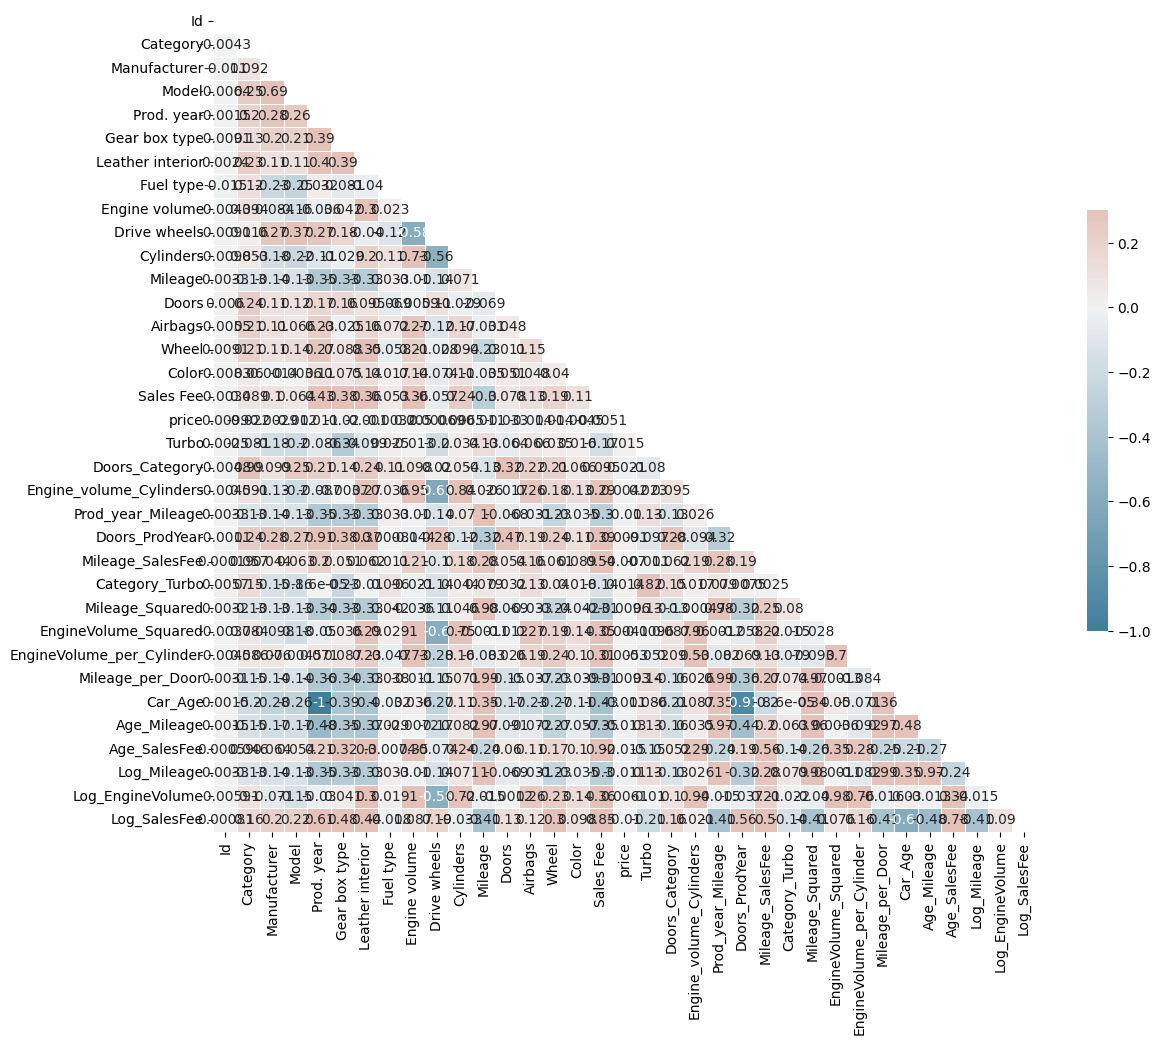

In [94]:
# Realizar un análisis de correlación
corr = df2.corr(method='pearson')
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11,9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

plt.tight_layout()
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={'shrink':0.5}, annot=True)

In [95]:
correlations = df2.corr()['price'].abs().sort_values(ascending=False)
print("Correlación con la variable objetivo (Curado):\n", correlations)

Correlación con la variable objetivo (Curado):
 price                        1.000000
Doors                        0.032986
Category                     0.021632
Doors_Category               0.021222
Gear box type                0.020325
Turbo                        0.015388
Age_SalesFee                 0.014557
Category_Turbo               0.014314
Wheel                        0.013929
Airbags                      0.013830
Age_Mileage                  0.013278
Model                        0.012115
Prod. year                   0.010756
Car_Age                      0.010756
Log_Mileage                  0.010523
Mileage                      0.010522
Prod_year_Mileage            0.010499
Log_SalesFee                 0.010103
Id                           0.009915
Mileage_Squared              0.009551
Mileage_per_Door             0.009313
Doors_ProdYear               0.009095
Mileage_SalesFee             0.006985
Cylinders                    0.006525
Log_EngineVolume             0.006075
En

# VARIABLES

In [96]:
df3 = df2
"""
Mileage_Squared              0.009551
Mileage_per_Door             0.009313
Doors_ProdYear               0.009095
Mileage_SalesFee             0.006985
Cylinders                    0.006525
Log_EngineVolume             0.006075
EngineVolume_per_Cylinder    0.005289
Sales Fee                    0.005070
Engine volume                0.005026
Color                        0.004539
Engine_volume_Cylinders      0.004228
EngineVolume_Squared         0.004103
Fuel type                    0.003239
Manufacturer                 0.002938
Leather interior             0.000998
Drive wheels                 0.000685
"""
df3 = df3.drop('Mileage_Squared', axis=1)
df3 = df3.drop('Mileage_per_Door', axis=1)
df3 = df3.drop('Doors_ProdYear', axis=1)
df3 = df3.drop('Mileage_SalesFee', axis=1)
df3 = df3.drop('Cylinders', axis=1)
df3 = df3.drop('Log_EngineVolume', axis=1)
df3 = df3.drop('EngineVolume_per_Cylinder', axis=1)
df3 = df3.drop('Sales Fee', axis=1)
df3 = df3.drop('Engine volume', axis=1)
df3 = df3.drop('Color', axis=1)
df3 = df3.drop('Engine_volume_Cylinders', axis=1)
df3 = df3.drop('EngineVolume_Squared', axis=1)
df3 = df3.drop('Fuel type', axis=1)
df3 = df3.drop('Manufacturer', axis=1)
df3 = df3.drop('Leather interior', axis=1)
df3 = df3.drop('Drive wheels', axis=1)
df3.head()

,Id,Category,Model,Prod. year,Gear box type,Mileage,Doors,Airbags,Wheel,price,Turbo,Doors_Category,Prod_year_Mileage,Category_Turbo,Car_Age,Age_Mileage,Age_SalesFee,Log_Mileage,Log_SalesFee
0,2680,0.287567,0.022567,2014.0,0.702832,0.000061,4,4,0.922512,22433,0,1.150266,0.123173,0.0,10.0,0.000612,7770.0,0.000061,6.656727
1,5960,0.453183,0.000428,2002.0,0.702832,0.003272,4,2,0.922512,7500,0,1.812733,6.582839,0.0,22.0,0.043055,0.0,0.003270,0.000000
2,2185,0.287567,0.027521,2014.0,0.702832,0.000122,4,4,0.922512,27284,0,1.150266,0.246346,0.0,10.0,0.001223,6390.0,0.000122,6.461468
3,15905,0.453183,0.000061,2000.0,0.096875,0.003272,4,4,0.922512,3450,0,1.812733,6.582839,0.0,24.0,0.043055,0.0,0.003270,0.000000
4,15337,0.018592,0.022690,2015.0,0.702832,0.000061,4,4,0.922512,26644,0,0.074369,0.123234,0.0,9.0,0.000550,2772.0,0.000061,5.733341


In [97]:
df4 = df3
y = df4['price']
x = df4.drop('price', axis=1)

# MODELO

In [98]:
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=101)

# Define the objective function for Bayesian optimization
def xgb_evaluate(max_depth, learning_rate, n_estimators, subsample, colsample_bytree):
    params = {
        'objective': 'reg:squarederror',
        'max_depth': int(max_depth),
        'learning_rate': learning_rate,
        'n_estimators': int(n_estimators),
        'subsample': subsample,
        'colsample_bytree': colsample_bytree,
        'random_state': 42
    }
    model = xgb.XGBRegressor(**params)
    
    # Fit model with early stopping
    model.fit(
        x_train, y_train,
        eval_set=[(x_test, y_test)],
        verbose=False
    )
    
    # Predict and calculate RMSE
    y_val_pred = model.predict(x_test)
    rmse = mean_squared_error(y_test, y_val_pred)
    
    # Return negative RMSE for maximization
    return -rmse

# Define parameter bounds for Bayesian optimization
param_bounds = {
    'max_depth': (5, 15),
    'learning_rate': (0.001, 0.05),
    'n_estimators': (1000, 4000),
    'subsample': (0.6, 1.0),
    'colsample_bytree': (0.4, 0.9)
}

# Run Bayesian optimization
optimizer = BayesianOptimization(
    f=xgb_evaluate,
    pbounds=param_bounds,
    random_state=42,
    verbose=2
)
optimizer.maximize(init_points=10, n_iter=25)

# Extract best parameters
best_params = optimizer.max['params']
best_params['max_depth'] = int(best_params['max_depth'])
best_params['n_estimators'] = int(best_params['n_estimators'])

print("Best parameters found:")
print(best_params)

# Train the final model with best parameters on the entire training set
final_model = xgb.XGBRegressor(objective="reg:squarederror", **best_params)
final_model.fit(
    x_train, y_train,
    eval_set=[(x_test, y_test)],
    verbose=False
)

# Make predictions and evaluate final model
predictions = final_model.predict(x_test)
final_rmse = mean_squared_error(y_test, predictions)
print("Final RMSE on test set:", final_rmse)


|   iter    |  target   | colsam... | learni... | max_depth | n_esti... | subsample |
-------------------------------------------------------------------------------------
| 1         | -1.694e+1 | 0.5873    | 0.04759   | 12.32     | 2.796e+03 | 0.6624    |
| 2         | -1.693e+1 | 0.478     | 0.003846  | 13.66     | 2.803e+03 | 0.8832    |
| 3         | -1.693e+1 | 0.4103    | 0.04853   | 13.32     | 1.637e+03 | 0.6727    |
| 4         | -1.693e+1 | 0.4917    | 0.01591   | 10.25     | 2.296e+03 | 0.7165    |
| 5         | -1.693e+1 | 0.7059    | 0.007835  | 7.921     | 2.099e+03 | 0.7824    |
| 6         | -1.693e+1 | 0.7926    | 0.01078   | 10.14     | 2.777e+03 | 0.6186    |
| 7         | -1.693e+1 | 0.7038    | 0.009356  | 5.651     | 3.847e+03 | 0.9863    |
| 8         | -1.694e+1 | 0.8042    | 0.01593   | 5.977     | 3.053e+03 | 0.7761    |
| 9         | -1.694e+1 | 0.461     | 0.02526   | 5.344     | 3.728e+03 | 0.7035    |
| 10        | -1.694e+1 | 0.7313    | 0.01627   | 10.2

In [99]:
xgb_reg = xgb.XGBRegressor(objective="reg:squarederror", **best_params)
xgb_reg.fit(x_train, y_train)
predictions = xgb_reg.predict(x_test)

# EVALUACIÓN

In [100]:
#print('Accuracy: ', metrics.accuracy_score(y_test,predictions))
print((root_mean_squared_error(predictions, y_test)))

411495.34359681484


In [101]:
scores = cross_val_score(xgb_reg, x, y, cv=10, scoring='f1_weighted')
print("Scores de cada fold:", scores)
print("Promedio del F1 score:", scores.mean())

c:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py", line 1293, in f1_score
    return fbeta_score(
           ^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\sklearn\utils\_param_validation.py", li

Scores de cada fold: [nan nan nan nan nan nan nan nan nan nan]
Promedio del F1 score: nan


c:\Python312\Lib\site-packages\sklearn\model_selection\_validation.py:1000: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "c:\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 139, in __call__
    score = scorer._score(
            ^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\sklearn\metrics\_scorer.py", line 376, in _score
    return self._sign * self._score_func(y_true, y_pred, **scoring_kwargs)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\sklearn\utils\_param_validation.py", line 213, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\sklearn\metrics\_classification.py", line 1293, in f1_score
    return fbeta_score(
           ^^^^^^^^^^^^
  File "c:\Python312\Lib\site-packages\sklearn\utils\_param_validation.py", li

# OUTPUT FILE

In [ ]:

df_eval = pd.read_csv('../data/Evaluation2.csv', sep=';', encoding='latin1')

df_eval['Turbo'] = df_eval['Engine volume'].map(turbo)

df_eval['Sales Fee'] = df_eval['Sales Fee'].map(to_zero)
df_eval['Mileage'] = df_eval['Mileage'].map(mileage_km)
df_eval['Engine volume'] = df_eval['Engine volume'].map(engine_volume)
df_eval['Doors'] = df_eval['Doors'].map(doors)

df_eval['Category'] = df_eval['Category'].map(freq_category).fillna(0)
df_eval['Manufacturer'] = df_eval['Manufacturer'].map(freq_manufacturer)
df_eval['Model'] = df_eval['Model'].map(freq_model)
df_eval['Gear box type'] = df_eval['Gear box type'].map(freq_gear_box_type)
df_eval['Leather interior'] = df_eval['Leather interior'].map(freq_leather_interior)
df_eval['Fuel type'] = df_eval['Fuel type'].map(freq_fuel_type)
df_eval['Drive wheels'] = df_eval['Drive wheels'].map(freq_drive_wheels)
df_eval['Mileage'] = df_eval['Mileage'].map(freq_mileage)
df_eval['Wheel'] = df_eval['Wheel'].map(freq_wheel)
df_eval['Color'] = df_eval['Color'].map(freq_color)

for col in df_eval.columns:
    df_eval[col] = pd.to_numeric(df_eval[col])

# Interaction terms
df_eval['Doors_Category'] = df_eval['Doors'] * df_eval['Category']
df_eval['Engine_volume_Cylinders'] = df_eval['Engine volume'] * df_eval['Cylinders']
df_eval['Prod_year_Mileage'] = df_eval['Prod. year'] * df_eval['Mileage']

# Additional interaction terms
df_eval['Doors_ProdYear'] = df_eval['Doors'] * df_eval['Prod. year']
df_eval['Mileage_SalesFee'] = df_eval['Mileage'] * df_eval['Sales Fee']
df_eval['Category_Turbo'] = df_eval['Category'] * df_eval['Turbo']

# Polynomial terms
df_eval['Mileage_Squared'] = df_eval['Mileage'] ** 2
df_eval['EngineVolume_Squared'] = df_eval['Engine volume'] ** 2

# Ratios
df_eval['EngineVolume_per_Cylinder'] = df_eval['Engine volume'] / df_eval['Cylinders']
df_eval['Mileage_per_Door'] = df_eval['Mileage'] / df_eval['Doors']

# Age feature
df_eval['Car_Age'] = 2024 - df_eval['Prod. year']

# Interaction with age
df_eval['Age_Mileage'] = df_eval['Car_Age'] * df_eval['Mileage']
df_eval['Age_SalesFee'] = df_eval['Car_Age'] * df_eval['Sales Fee']

# Log transformations (to handle skewness)
df_eval['Log_Mileage'] = np.log1p(df_eval['Mileage'])
df_eval['Log_EngineVolume'] = np.log1p(df_eval['Engine volume'])
df_eval['Log_SalesFee'] = np.log1p(df_eval['Sales Fee'])


df_eval = df_eval.drop('Mileage_Squared', axis=1)
df_eval = df_eval.drop('Mileage_per_Door', axis=1)
df_eval = df_eval.drop('Doors_ProdYear', axis=1)
df_eval = df_eval.drop('Mileage_SalesFee', axis=1)
df_eval = df_eval.drop('Cylinders', axis=1)
df_eval = df_eval.drop('Log_EngineVolume', axis=1)
df_eval = df_eval.drop('EngineVolume_per_Cylinder', axis=1)
df_eval = df_eval.drop('Sales Fee', axis=1)
df_eval = df_eval.drop('Engine volume', axis=1)
df_eval = df_eval.drop('Color', axis=1)
df_eval = df_eval.drop('Engine_volume_Cylinders', axis=1)
df_eval = df_eval.drop('EngineVolume_Squared', axis=1)
df_eval = df_eval.drop('Fuel type', axis=1)
df_eval = df_eval.drop('Manufacturer', axis=1)
df_eval = df_eval.drop('Leather interior', axis=1)
df_eval = df_eval.drop('Drive wheels', axis=1)

print(df_eval)

TypeError: can't multiply sequence by non-int of type 'float'

In [ ]:
for col in df_eval.columns:
    if col == 'Id':
        continue
    df_eval[col] = pd.to_numeric(df_eval[col])

print(df_eval)

         Id  Category  Prod. year  Gear box type  Doors  Airbags     Wheel  \
0     15246  0.453183        2014       0.702832      4        6  0.922512   
1      5176  0.453183        2013       0.702832      4       12  0.922512   
2      3143  0.287567        2009       0.702832      4        4  0.922512   
3      3360  0.287567        2011       0.096875      2        2  0.922512   
4      3105  0.027093        2013       0.702832      4       12  0.922512   
...     ...       ...         ...            ...    ...      ...       ...   
2881  17665  0.453183        2009       0.702832      4       12  0.922512   
2882   6554  0.287567        2015       0.702832      4       12  0.922512   
2883  18661  0.453183        2014       0.702832      4        0  0.077488   
2884   6825  0.453183        2014       0.702832      4        4  0.922512   
2885  11266  0.015779        1996       0.096875      4        2  0.922512   

      Turbo  
0         0  
1         0  
2         0  
3      

In [ ]:
output = xgb_reg.predict(df_eval)
id_column = df_eval['Id']

predicted_df = pd.DataFrame({
    'id': id_column,
    'price': output
})

#print(predicted_df)

In [ ]:
predicted_df.to_csv('../results/21.csv', index=False)